## Application of NMRQNet on plasma samples collected with EDTA as the anticoagulant


### Loading packages





In [1]:
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp

import os
import sys
import random
import numpy as np
from numpy import array
import time
from functools import partial
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure,axvline
import pandas as pd
from copy import deepcopy
import tqdm
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'


If using Google Colab, connect to the google drive to load the data and save the results

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p drive
os.chdir('drive/MyDrive/')  

Mounted at /content/drive


### Load plasma samples and reference library

In [3]:
#plasma samples
hp_data=pd.read_csv('./tutorial_data/example_hp_EDTA.csv')
test_data=np.array(hp_data)[:,2:].T
test_data=test_data.reshape((test_data.shape[0],test_data.shape[1],1))
ppm=hp_data['ppm']

In [4]:
#reference library
total_lib=pd.read_csv('./tutorial_data/library_for_EDTA_plasma.csv')
total_lib.index=total_lib['Unnamed: 0']
del total_lib['Unnamed: 0']
print(total_lib.shape)

(69, 12000)


Visualization of the raw NMR spectrum

Text(0, 0.5, 'Intensity (a.u.)')

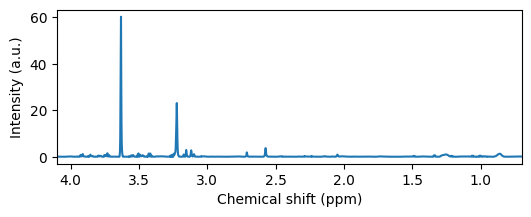

In [6]:
n=0 #spectrum index
plt.figure(figsize=[6,2])
plt.plot(ppm,test_data[n,:,0])
plt.xlim(4.1,0.7)
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")

### Initialize the quantifications with CRNN predictions
We load weights from the pre-trained CRNN model and make the initial predictions for components within each plasma spectrum.

In [8]:
from prediction_dp_edta import Test_data
pred_test_data=Test_data(test_data = test_data)
predict_test_hp=pred_test_data.pred_with_deep_learning_edta(weight='./model_plasma_quant/model_plasma_quant')


In [10]:
#number of samples, number of components in the reference library
print(predict_test_hp.shape)

(2, 69)


### Fit and remove free EDTA peaks
The stochastic hillclimbing is used to explore the positions for two free EDTA peaks.

Note that to achieve better alignment on your data, you may need to increase n_iter = 1000, step_range=200.

In [11]:
from find_free_edta import find_free_edta
original_hp = test_data.reshape((test_data.shape[0],test_data.shape[1]))
find_free_edta_class = find_free_edta(original_hp = original_hp, total_lib = np.array(total_lib))

In [12]:
#range(0,2) specifies the sample range you would like to process
#total specifies the number of samples to process
pool = mp.Pool(4)
find_results = list(tqdm.tqdm(pool.imap(partial(find_free_edta_class.find_free_edta, predict_test_hp = predict_test_hp,
                                                                 n_iter= 1000, step_range = 200, min_concen = 0.2,
                                                                 max_concen = 10),range(0,2)),total = 2,position=0))


100%|██████████| 2/2 [00:35<00:00, 17.62s/it]


Examine the fitting results by plotting the free EDTA peaks in the original plasma specrum and the fitted spectrum

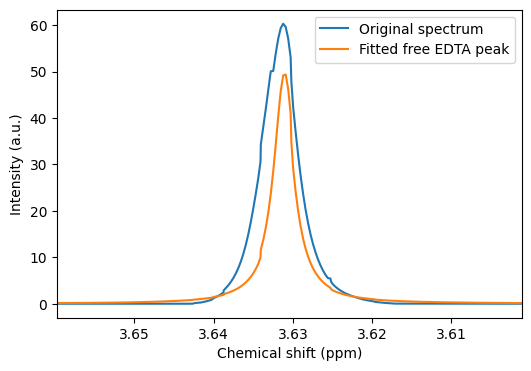

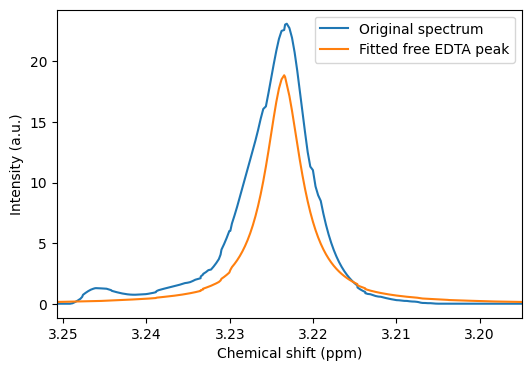

In [13]:
from remove_free_edta import remove_free_edta
remove_class = remove_free_edta(original_hp, find_results)
remove_class.plot_fit_edta_peaks(n=0, ppm = ppm) #n is the spectrum index

Based on the fitting positions, the free EDTA peaks are removed from the mixture

In [15]:

remove_results = list(tqdm.tqdm(pool.imap(partial(remove_class.remove_free_edta, ppm = ppm),range(0,2)),
                                total = 2, position =0))

100%|██████████| 2/2 [00:00<00:00,  8.82it/s]


Visualize the processed plasma spectrum again

Text(0, 0.5, 'Intensity (a.u.)')

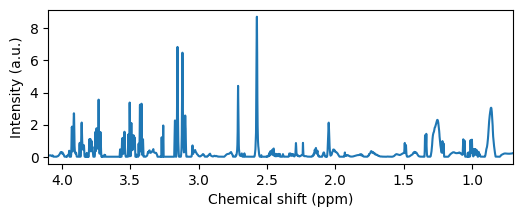

In [16]:
###area under the curve is 1
n=0 # spectrum id
plt.figure(figsize=[6,2])
plt.plot(ppm,np.array(remove_results)[n,:])
plt.xlim(4.1,0.7)
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")

### Initialize the quantifications with CRNN on the processed plasma samples

In [17]:
from prediction_dp_noedta import Test_data
update_test_data = np.array(remove_results).reshape((len(remove_results),12000,1)) #reshape the input based on the remove_results

pred_test_data_update=Test_data(test_data = update_test_data)
predict_test_hp_update=pred_test_data_update.pred_with_deep_learning(weight='./model_plasma_quant/model_plasma_quant')
predict_test_hp_update.shape #number of samples, number of components in the reference library

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(2, 69)

Visualize the inital prediction results

Text(0, 0.5, 'Intensity (a.u.)')

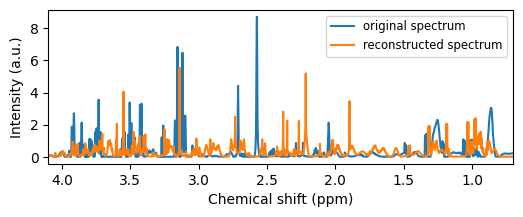

In [26]:
n=0 #spectrum index
reconstr=np.matmul(predict_test_hp_update[n,:], total_lib) #reconstruct the whole spectrum from predicted results and the reference library
plt.figure(figsize=[6,2])
plt.plot(ppm,update_test_data[n,:,0],label="original spectrum")
plt.plot(ppm,np.array(reconstr),label = "reconstructed spectrum")
plt.legend(loc="best",fontsize = "small")
plt.xlim(4.1,0.7)
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")

### Global positional correction to better align the results

In [27]:
from global_correction_edta import pair_original_reconstr
pair_class = pair_original_reconstr(predict_test_hp = predict_test_hp_update, #predicted results
                                    original_hp = update_test_data) #processed plasma spectra

In [28]:
#region*region_step = 12000, the input shape
#region_step could be further minimized with the increase of region to optimize the results
pool = mp.Pool(4)
global_correct_spectra=list(tqdm.tqdm(pool.imap(partial(pair_class.global_correct, 
                                                        total_lib=np.array(total_lib),region=30, region_step=400),range(0,2)),
                                      total = 2, position = 0))


100%|██████████| 2/2 [00:16<00:00,  8.43s/it]


In [30]:
best_step = []
for i in range(0,len(global_correct_spectra)):
  best_step.append(global_correct_spectra[i][1]) 

best_step #estimated global correction step for each sample

[96, 92]

Visualize the global positional corrected spectra

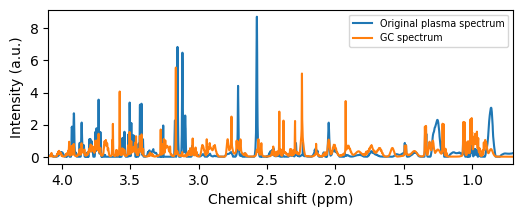

In [39]:
a=0 #a,b are tuned to check regional alignment
b=12000
n=0 #spectrum index, tuned to check different spectra
plt.figure(figsize=[6,2])
plt.plot(ppm[a:b],update_test_data[n,:,0][a:b],label="Original plasma spectrum") #processed plasma spectrum
plt.plot(ppm[a:b],np.array(global_correct_spectra[n][0])[a:b],label="GC spectrum") #Global corrected spectrum
plt.xlim(np.max(ppm[a:b]),np.min(ppm[a:b]))
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")
plt.legend(loc="best",fontsize = "x-small")
plt.show()

### Optimize on positions and concentrations with stochastic hill climbing

In [40]:
from optimize_stochastic_hillclimbing_edta import optimize_pos_concen
opt_pos_concen_class = optimize_pos_concen(predict_test_hp_update = predict_test_hp_update, remove_results = remove_results)



*   Note that to further optimize the performance on your data, you may need to increase n_iter=500, step_range=50, max_concen=10, and decrease min_concen=0.2
*   Default parameters are able to deal with most cases



In [41]:
pool = mp.Pool(4)
opt_pos_concen_results = list(tqdm.tqdm(pool.imap(partial(opt_pos_concen_class.optimize_pos_concen, n_iter= 500, 
                                                          total_lib=total_lib, best_step=best_step,step_range = 50, 
                                                          min_concen = 0.2,max_concen = 10),range(0,2)),
                                        total = 2,position =0))


100%|██████████| 2/2 [05:40<00:00, 170.26s/it]


Visualize the reconstructed spectrum after the optimization step

Mean squared error between the original and reconstructed spectra: 0.04426835538355604


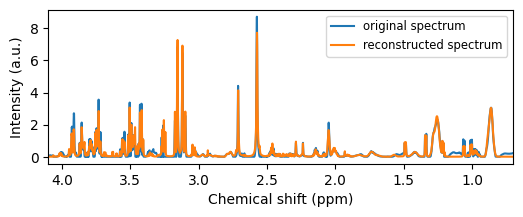

In [44]:
n=0 #spectrum index
print('Mean squared error between the original and reconstructed spectra:',opt_pos_concen_results[n][1])
a=0
b=12000
plt.figure(figsize=[6,2])
plt.plot(ppm[a:b],remove_results[n][a:b],label="original spectrum")
plt.plot(ppm[a:b],(np.matmul(opt_pos_concen_results[n][0],opt_pos_concen_results[n][2])/np.sum(opt_pos_concen_results[n][0]))[a:b],
         label = "reconstructed spectrum")
plt.xlim((4.1,0.7))
plt.legend(loc="best",fontsize="small")
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")
plt.show()

### Further optimize the performence on concentrations with stochastic hill climbing

This step provides the option for user to further boost the performance by optimizing only on concentration

In [46]:
from optimize_concen_edta import optimize_concen
opt_concen_class= optimize_concen(opt_pos_concen_results, remove_results)

In [47]:
pool = mp.Pool(4)
opt_concen_results = list(tqdm.tqdm(pool.imap(partial(opt_concen_class.optimize_concen, n_iter= 1000, 
                                                      min_concen = 0.2,max_concen = 10),
                                              range(0,2)),total = 2, position =0))


100%|██████████| 2/2 [02:24<00:00, 72.29s/it] 


Visualize the reconstructed spectrum after all the optimization steps

Mean squared error between the original and reconstructed spectra: 0.04208077354973266


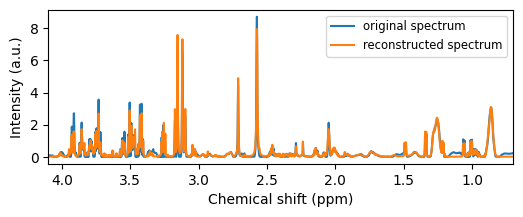

In [64]:
n=0
print('Mean squared error between the original and reconstructed spectra:',opt_concen_results[n][1])

plt.figure(figsize=[6,2])
plt.plot(ppm,remove_results[n],label="original spectrum")
plt.plot(ppm,(np.matmul(opt_concen_results[n][0],
                             opt_pos_concen_results[n][2])/np.sum(opt_concen_results[n][0])),label="reconstructed spectrum")
plt.xlim(np.max(ppm),np.min(ppm))
plt.legend(loc="best",fontsize="small")
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")
plt.show()

### Final visualization check

Regional check between the original spectrum and the final reconstructed spectrum

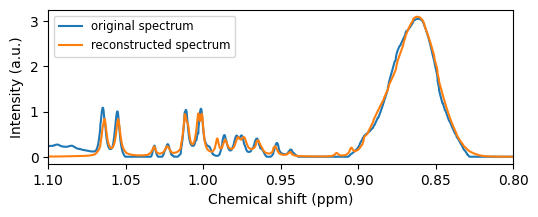

In [63]:
n=0 #spectrum index
a=0.8 #a,b are tuned to specify the chemical shift region
b=1.1
plt.figure(figsize=[6,2])
plt.plot(ppm[(ppm>a) & (ppm<b)],remove_results[n][(ppm>a) & (ppm<b)],label="original spectrum")
plt.plot(ppm[(ppm>a) & (ppm<b)],(np.matmul(opt_concen_results[n][0],
                             opt_pos_concen_results[n][2])/np.sum(opt_concen_results[n][0]))[(ppm>a) & (ppm<b)],label="reconstructed spectrum")
plt.xlim(b,a)
plt.legend(loc="best",fontsize="small")
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")
plt.show()

Visualize the mapping performance for individual metabolite

Glucose


Text(0, 0.5, 'Intensity (a.u.)')

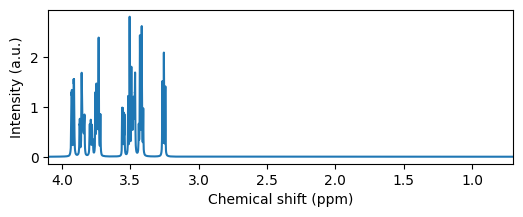

In [65]:
n=0 #spectrum index
meta_name=np.array(total_lib.index) #extract metabolite list
meta_index=np.where(meta_name=="Glucose")[0][0] #change metabolite name here or specify the index in the next line
#meta_index = 0
print(meta_name[meta_index])

#reconstruct the metabolite-specific spectrum based on the estimated concentrations and the library
quant_meta=(opt_concen_results[n][0][meta_index]/np.sum(opt_concen_results[n][0]))*opt_pos_concen_results[n][2][meta_index,:]
plt.figure(figsize=(6,2))
plt.plot(ppm,quant_meta)
plt.xlim(4.1,0.7)
plt.xlabel("Chemical shift (ppm)")
plt.ylabel("Intensity (a.u.)")


Text(0, 0.5, 'Intensity (a.u.)')

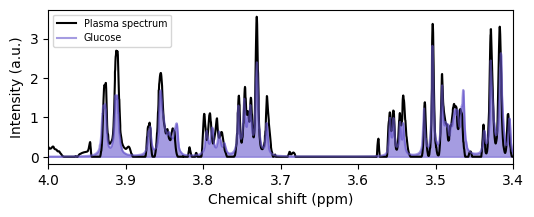

In [75]:
#Align the reconstructed metabolite-specific spectrum to the original plasma spectrum
a=3.4
b=4
fig, ax = plt.subplots(figsize=(6,2))
ax.plot(ppm[(ppm>a) & (ppm<b)],remove_results[n][(ppm>a) & (ppm<b)],color="black",label="Plasma spectrum")
ax.plot(ppm[(ppm>a) & (ppm<b)],quant_meta[(ppm>a) & (ppm<b)],color="slateblue",alpha=0.6,label=meta_name[meta_index])
ax.set_xlim(b,a)
ax.fill_between(ppm[(ppm>a) & (ppm<b)], 0, quant_meta[(ppm>a) & (ppm<b)], color="slateblue",alpha=0.6)
ax.legend(loc="best",fontsize="x-small")
ax.set_xlabel("Chemical shift (ppm)")
ax.set_ylabel("Intensity (a.u.)")


### Save the results

In [76]:
output_path = './results/'

for n in range(0,2): #n is spectrum index
  coef_file = output_path+str('coef_'+str(n+1)+'.txt')
  lib_file = output_path +str('lib_'+str(n+1)+'.txt')
  hp_file = output_path + str('processed_hp_'+str(n+1)+'.txt')
  
  np.savetxt(coef_file,opt_concen_results[n][0])
  np.savetxt(lib_file,opt_pos_concen_results[n][2])
  np.savetxt(hp_file,remove_results[n])
